In [1]:
import os
import glob
import itertools
import copy
import sys
sys.path.insert(1, '/home/fpei2/learning/ttrnn/')

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

from ttrnn.trainer import A2C
from ttrnn.tasks.harlow import HarlowMinimal, Harlow1D, HarlowMinimalDelay
from neurogym.wrappers import PassAction, PassReward, Noise
from ttrnn.tasks.wrappers import DiscreteToBoxWrapper, RingToBoxWrapper, ParallelEnvs

np.random.seed(0)

# Meta-RL Agent on Harlow Task

## 1 Task and Model

### 1.1 Task Implementation

The task is a simplified version of the Harlow task, modified to more closely resemble typical neuroscience tasks modeled with RNNs. Input 0 is a fixation input, which is 1 for fixation, stimulus, and delay periods and flips to 0 as a go cue during the decision period. Inputs 1-5 are the "object" presented on the "left", while inputs 6-10 are the "object" presented on the "right". "Objects" are random 5-d vectors sampled from a standard normal distribution, then orthogonalized with Gram-Schmidt. Imputs 11-13 are the past action (fixate, choose left, or choose right), one-hot encoded, and input 14 is the past reward.

Task inputs and ground-truth outputs are shown below.

In [2]:
# Build task env

task = HarlowMinimalDelay(
    dt=100,
    obj_dim=5,
    obj_mode="kb", 
    obj_init="normal",
    orthogonalize=True,
    abort=False,
    rewards={'abort': -0.1, 'correct': 1.0, 'fail': 0.0},
    timing={'fixation': 200, 'stimulus': 400, 'delay': 200, 'decision': 200},
    num_trials_before_reset=6,
    r_tmax=-1.0,
)
task.seed(0)

[0]

Text(0.5, 0, 'Step')

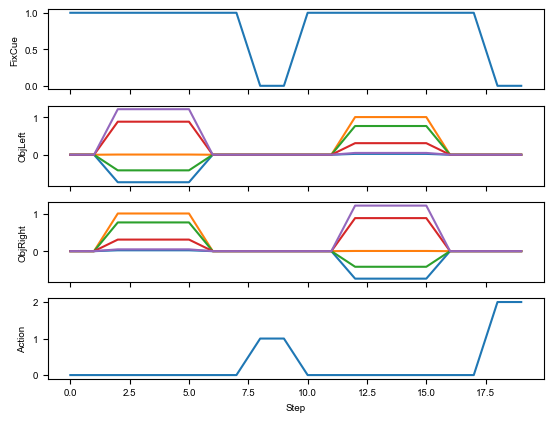

In [3]:
# Plot a few trials of task

n_plot_trials = 2
ob_list = []
gt_list = []
for _ in range(n_plot_trials):
    _ = task.new_trial()
    ob_list.append(task.ob)
    gt_list.append(task.gt)
_ = task.reset()

obs = np.concatenate(ob_list, axis=0)
gts = np.concatenate(gt_list, axis=0)

fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(obs[:, 0])
axs[0].set_ylabel('FixCue')
axs[1].plot(obs[:, 1:6])
axs[1].set_ylabel('ObjLeft')
axs[2].plot(obs[:, 6:11])
axs[2].set_ylabel('ObjRight')
axs[3].plot(gts[:])
axs[3].set_ylabel('Action')
axs[3].set_xlabel('Step')

Importantly, the two objects presented switch every 6 trials. Within each 6-trial block, the rewarded object is kept constant.

### 1.2 Model Performance

As reported in Wang et al. 2017, a meta-RL agent can learn to learn the rewarded object in a one-shot manner by randomly guessing on the first trial and following a simple win-stay lose-shift strategy. We reproduce this result with our modified task implementation using a discretized GRU.

In [4]:
# Add env wrappers for meta-RL

_ = task.reset()

wrappers = [
    (Noise, {'std_noise': 0.1}),
    (PassAction, {'one_hot': True}), 
    (PassReward, {}), 
    (ParallelEnvs, {'num_envs': 1}),
]

if len(wrappers) > 0:
    for wrapper, wrapper_kwargs in wrappers:
        task = wrapper(task, **wrapper_kwargs)

In [5]:
# Load trained model from checkpoint

ckpt_path = "/home/fpei2/learning/harlow_analysis/runs/harlowdelay3_gru256/epoch=19999-step=20000-v1.ckpt"

pl_module = A2C.load_from_checkpoint(ckpt_path, env=task)
model = pl_module.model
model.rnn.update_cache()

In [6]:
# Run model on task

num_episodes = 40
episode_count = 0

ob, _ = task.reset()
hx = model.rnn.build_initial_state(1, pl_module.device, pl_module.dtype)

avg_episode_performance = np.zeros(6, dtype=float)
episode_performance = []
trial_count = 0

while episode_count < num_episodes:
    action_logits, value, hx = model(
        torch.from_numpy(ob).to(device=pl_module.device, dtype=pl_module.dtype), 
        hx=hx, 
        cached=True)
    action = action_logits.sample().detach().cpu().numpy()

    ob, reward, done, trunc, info = task.step(action)

    if info.get('new_trial', False):
        trial_count += 1
        episode_performance.append(info.get('performance', 0.0))
        if trial_count == 6:
            avg_episode_performance += np.array(episode_performance).squeeze() / num_episodes
            trial_count = 0
            episode_performance = []
            episode_count += 1

Text(0, 0.5, 'Avg Performance')

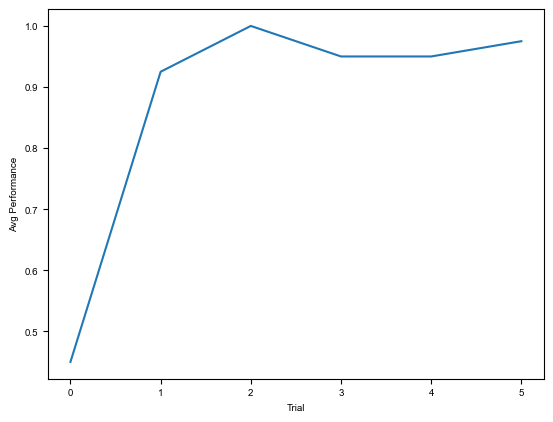

In [7]:
plt.plot(avg_episode_performance)
plt.xlabel('Trial')
plt.ylabel('Avg Performance')

After receiving feedback on its choice on the first trial, the network is able to adjust its policy and improve performance from chance to almost perfect, resembling the reported performance of trained macaques. Note also that the network state is not reset before each new episode, so the network is capable of performing this task continuously with new objects introduced at arbitrary times. Thus, the behavior of the network is quite similar to that of animals. However, it does all of this without weight changes, which might not match biological network solutions, since they may rely on short-term and long-term plasticity. 

## 2 Network Solution

### 2.1 Overview

We now look at how the network performs this task. We focus on the first two trials of each episode, where, depending on reward, the network either keeps its current policy or switches to the opposite policy. For visualization purposes, we reset the network state to 0 at the beginning of each episode. This has the unfortunate effect of making the network's choice on the first trial deterministic (explained more thoroughly later).

A series of network trajectories were generated for 20 pairs of objects. For each object pair, we simulate 8 conditions, generated by toggling 1) which object is rewarded, 2) which object is presented on the left in the first trial, and 3) which object is presented on the left in the second trial.

In [8]:
# Load trajectories

template_path = "/home/fpei2/learning/harlow_analysis/runs/harlowdelay3_gru256/trajectories/epoch19999-v1_sample_multi{}.npz"

num_objsets = 20

states_list = []
condition_list = []
obj_list = []
for i in range(num_objsets):
    trajectories = np.load(template_path.format(i))
    states_list.append(trajectories['states'])
    condition_list.append(trajectories['condition'])
    obj_list.append((trajectories['obj1'], trajectories['obj2']))

states = np.stack(states_list) # objset x cond x trial x time x dim
conditions = np.stack(condition_list) # objset x cond x feat
feat_names = [
    'objset', # (arbitrary) index of set of objects used as stimulus
    'reward_idx', # which object is rewarded
    'obj_left_1', # which object presented on left in first trial
    'choice', # which object was chosen in first trial,
    'obj_left_2', # which object presented on left in second trial
]

We apply PCA to the condition-averaged trajectories.

In [9]:

## PCA

all_mean = states.mean(axis=(0,1,2,3), keepdims=True) # mean channel value
states_c = states - all_mean # centered data

condition_means = states_c.mean(axis=2)

condition_means_stacked = condition_means.reshape(-1, condition_means.shape[-1])

pca_allcond = PCA()
allcond_pca = pca_allcond.fit_transform(condition_means_stacked)

max_dim = min(allcond_pca.shape[0], condition_means.shape[-1])
condition_means_pca = allcond_pca.reshape(condition_means.shape[:-1] + (max_dim,))

print(np.cumsum(pca_allcond.explained_variance_ratio_)[:8])

[0.33988354 0.46330932 0.5810503  0.66815454 0.7257848  0.77137166
 0.809448   0.84468955]


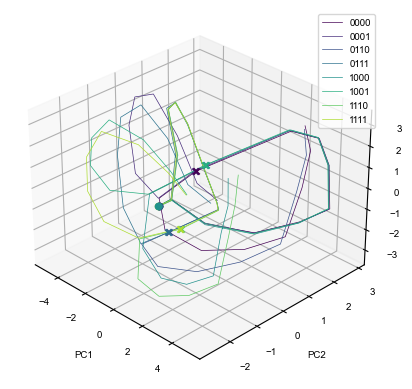

In [10]:
# Plot trajectories for one object set

objset = 0

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, feats in enumerate(conditions[objset]):
    feat_name = ''.join([str(fn) for fn in feats])[1:]
    color = plt.get_cmap('viridis')(i / len(conditions[objset]))
    ax.plot(condition_means_pca[objset][i][:, 0], condition_means_pca[objset][i][:, 1], 
        condition_means_pca[objset][i][:, 2], linewidth=0.5, label=feat_name, color=color)
    ax.scatter(condition_means_pca[objset][i][0, 0], condition_means_pca[objset][i][0, 1], 
        condition_means_pca[objset][i][0, 2], marker='o', color=color)
    ax.scatter(condition_means_pca[objset][i][9, 0], condition_means_pca[objset][i][9, 1], 
        condition_means_pca[objset][i][9, 2], marker='x', color=color)
plt.legend()
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

ax.view_init(30, -45)

Here, condition labels describe four features of the trajectory:
* digit 1: which object is rewarded. '0' means object 1 is rewarded, '1' means object 2 is rewarded
* digit 2: which object is presented on the left in the first trial. '0' means object 1, '1' means object 2
* digit 3: which object was chosen by the network on the first trial. '0' means object 1, '1' means object 2. Note that this does not include all possible choices. The networks final choice is dependent on the inputs as well as the network's initial state at the beginning of stimulus. Because the network is re-initialized to zero on all trials, only one choice is possible depending on the order in which objects are presented (digit 2).
* digit 4: which object is presented on the left in the second trial. '0' means object 1, '1' means object 2. Although network choice on the first trial is entirely determined by object presentation order, on the second trial, the network chooses the correct object depending on which is rewarded, so object presentation order and choice are decoupled.

The results of PCA are somewhat misleading - the final endpoint of conditions '1000' and '1110' are the same action choice as '0001' and '0111', but they are quite far away from each other in this PC space. However, since we know network readout weights, we can also compute ground-truth fixation and choice axes. The fixation axis is the same as the readout axis corresponding to fixation. The choice axis is assigned to the vector pointing from the end of the left choice weights to the end of the right choice weights.

In [11]:
# Load readout weights

model_weights = torch.load(ckpt_path)['state_dict']
readout_weights = model_weights['model.actor.logits_net.weight'].detach().cpu().numpy()
del model_weights

In [12]:
## Compute fixation and choice axes

fix_axis = readout_weights[0]
left_axis = readout_weights[1]
right_axis = readout_weights[2]

def ortho(u, v):
    return u, (v - np.dot(u, v) / np.dot(u, u) * u)

# Orthogonalize left and right axes from fixation
_, left_axis_o = ortho(fix_axis, left_axis)
_, right_axis_o = ortho(fix_axis, right_axis)

# Compute angles
left_right_angle = np.arccos(np.dot(left_axis_o, right_axis_o) / (np.linalg.norm(left_axis_o) * np.linalg.norm(right_axis_o)))

fix_left_basis = np.stack([fix_axis, left_axis]).T # N x 2
fix_left_proj = np.linalg.inv(fix_left_basis.T @ fix_left_basis) @ (fix_left_basis.T @ right_axis_o[:, None])
right_residual = right_axis_o - (fix_left_basis @ fix_left_proj).squeeze()
right_plane_angle = np.arcsin(np.linalg.norm(right_residual) / np.linalg.norm(right_axis_o))
print(f'Angle between left and right choice axes: {left_right_angle / np.pi * 180}')
print(f'Angle between right choice axis and plane defined by left and fixation axes: {right_plane_angle / np.pi * 180}')

# Choice axis is diff between right and left
choice_axis = right_axis_o - left_axis_o

# Normalize
fix_axis /= np.linalg.norm(fix_axis)
choice_axis /= np.linalg.norm(choice_axis)

Angle between left and right choice axes: 150.73347769853044
Angle between right choice axis and plane defined by left and fixation axes: 29.266527310425897


We can then project the network trajectories onto these two axes.

In [13]:
## Project onto fixation and choice axes (and then PCA for the rest)

condition_means = states_c.mean(axis=2)

proj_fix_choice = np.stack([fix_axis, choice_axis]).T
condition_proj_means = condition_means @ proj_fix_choice
condition_ext_means = condition_means - condition_proj_means @ proj_fix_choice.T

condition_ext_means_stacked = condition_ext_means.reshape(-1, condition_ext_means.shape[-1])

pca_ext = PCA(n_components=(condition_ext_means_stacked.shape[-1] - 2))
ext_pca = pca_ext.fit_transform(condition_ext_means_stacked)

max_dim = min(ext_pca.shape[0], condition_ext_means.shape[-1] - 2)
condition_ext_means_pca = ext_pca.reshape(condition_ext_means.shape[:-1] + (max_dim,))
condition_ext_means_pca = np.concatenate([condition_proj_means, condition_ext_means_pca], axis=-1)

print(np.cumsum(pca_ext.explained_variance_ratio_)[:8])

[0.35494578 0.48609263 0.6022407  0.69448465 0.7465111  0.7873732
 0.8264228  0.84866834]


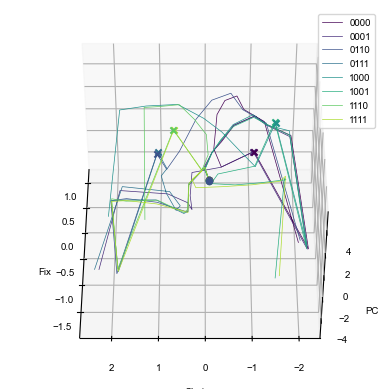

In [14]:
# Plot trajectories in fixation/choice space for one object set

objset = 0

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, feats in enumerate(conditions[objset]):
    feat_name = ''.join([str(fn) for fn in feats])[1:]
    color = plt.get_cmap('viridis')(i / len(conditions[objset]))
    ax.plot(condition_ext_means_pca[objset][i][:, 0], condition_ext_means_pca[objset][i][:, 1], 
        condition_ext_means_pca[objset][i][:, 2], linewidth=0.5, label=feat_name, color=color)
    ax.scatter(condition_ext_means_pca[objset][i][0, 0], condition_ext_means_pca[objset][i][0, 1], 
        condition_ext_means_pca[objset][i][0, 2], marker='o', color=color)
    ax.scatter(condition_ext_means_pca[objset][i][9, 0], condition_ext_means_pca[objset][i][9, 1], 
        condition_ext_means_pca[objset][i][9, 2], marker='x', color=color)
plt.legend()
ax.set_xlabel('Fix'); ax.set_ylabel('Choice'); ax.set_zlabel('PC')

ax.view_init(45, 180)

Now we can clearly see the two choices separated between conditions.

Further, we can compare trajectories across object sets.

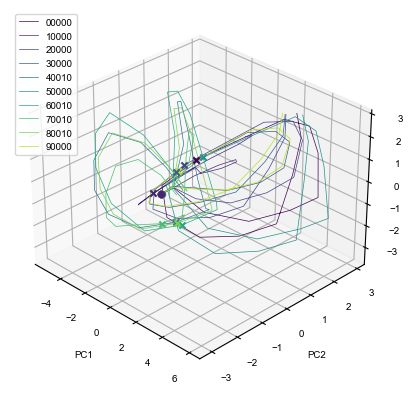

In [15]:
## Plot subset of conditions on multiple objsets

objset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conds = [0]

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, (objs, cd) in enumerate(itertools.product(objset, conds)):
    feat_name = ''.join([str(fn) for fn in conditions[objs, cd]])
    color = plt.get_cmap('viridis')(i / len(objset) / len(conds))
    ax.plot(condition_means_pca[objs][cd][:, 0], condition_means_pca[objs][cd][:, 1], 
        condition_means_pca[objs][cd][:, 2], linewidth=0.5, label=feat_name, color=color)
    ax.scatter(condition_means_pca[objs][cd][0, 0], condition_means_pca[objs][cd][0, 1], 
        condition_means_pca[objs][cd][0, 2], marker='o', color=color)
    ax.scatter(condition_means_pca[objs][cd][9, 0], condition_means_pca[objs][cd][9, 1], 
        condition_means_pca[objs][cd][9, 2], marker='x', color=color)
plt.legend()
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

ax.view_init(30, -45)

Here the condition labels have an additional digit at the beginning indicating the object set used (1-20). 

We can again project onto the fixation and choice axes for something less abstract.

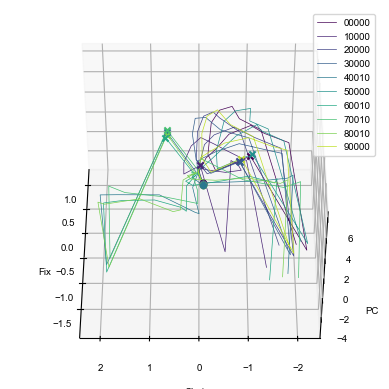

In [16]:
## Plot subset of conditions in fixation/choice space on multiple objsets

objset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conds = [0]

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, (objs, cd) in enumerate(itertools.product(objset, conds)):
    feat_name = ''.join([str(fn) for fn in conditions[objs, cd]])
    color = plt.get_cmap('viridis')(i / len(objset) / len(conds))
    ax.plot(condition_ext_means_pca[objs][cd][:, 0], condition_ext_means_pca[objs][cd][:, 1], 
        condition_ext_means_pca[objs][cd][:, 2], linewidth=0.5, label=feat_name, color=color)
    ax.scatter(condition_ext_means_pca[objs][cd][0, 0], condition_ext_means_pca[objs][cd][0, 1], 
        condition_ext_means_pca[objs][cd][0, 2], marker='o', color=color)
    ax.scatter(condition_ext_means_pca[objs][cd][9, 0], condition_ext_means_pca[objs][cd][9, 1], 
        condition_ext_means_pca[objs][cd][9, 2], marker='x', color=color)
plt.legend()
ax.set_xlabel('Fix'); ax.set_ylabel('Choice'); ax.set_zlabel('PC')

ax.view_init(45, 180)

### 2.2 Immediate Input Dynamics

To understand the network solution, we first break down how inputs - specifically the two objects - drive network state following fixation. To do this, we can look at the recurrent weights for the inputs, though GRU gating and non-linearities mean that this is a very rough approximation.

In [17]:
## Get recurrent weights for left and right objects

obj_left_weights = model.rnn.rnn_cell.weights.weight_ih[-256:, 1:6].detach().cpu().numpy().T
obj_right_weights = model.rnn.rnn_cell.weights.weight_ih[-256:, 6:11].detach().cpu().numpy().T

# Also project into PCA space
obj_left_weights_pca = pca_allcond.transform(obj_left_weights)
obj_right_weights_pca = pca_allcond.transform(obj_right_weights)

Looking at the projections of these weights in PCA space, we can see that they are (as one would expect) much stronger in the top few PCs. They are especially strong along the 1st, 3rd, and 7th PCs.

Text(0.5, 0, 'Right obj weights')

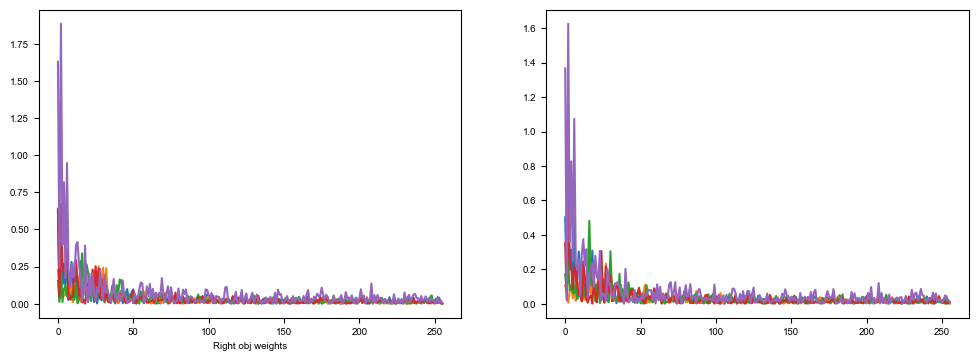

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.abs(obj_left_weights_pca).T)
axs[0].set_xlabel('Left obj weights')
axs[1].plot(np.abs(obj_right_weights_pca).T)
axs[0].set_xlabel('Right obj weights')

We also look at the angles between the weight vectors for matching input features, e.g. the first feature of the left object (index 1) and the first feature of the right object (index 6).

In [19]:
weight_angle = np.arccos(
    np.diag(np.dot(obj_left_weights, obj_right_weights.T)) / 
    np.linalg.norm(obj_left_weights, axis=1) /
    np.linalg.norm(obj_right_weights, axis=1)
)

num_pcs = 8
weight_angle_pca = np.arccos(
    np.diag(np.dot(obj_left_weights_pca[:, :num_pcs], obj_right_weights_pca[:, :num_pcs].T)) / 
    np.linalg.norm(obj_left_weights_pca[:, :num_pcs], axis=1) /
    np.linalg.norm(obj_right_weights_pca[:, :num_pcs], axis=1)
)

print(f'Angles between weight vectors: {np.round(weight_angle / np.pi * 180).tolist()}')
print(f'Angles between weight vectors in PCA space: {np.round(weight_angle_pca / np.pi * 180).tolist()}')

obj_left_weight_norm = np.linalg.norm(obj_left_weights, axis=1)
obj_right_weight_norm = np.linalg.norm(obj_right_weights, axis=1)

print(f'Left object weight vector magnitudes: {[round(olwn, 2) for olwn in obj_left_weight_norm]}')
print(f'Right object weight vector magnitudes: {[round(orwn, 2) for orwn in obj_right_weight_norm]}')

Angles between weight vectors: [143.0, 111.0, 113.0, 134.0, 162.0]
Angles between weight vectors in PCA space: [165.0, 139.0, 141.0, 160.0, 172.0]
Left object weight vector magnitudes: [1.31, 0.81, 0.84, 1.33, 3.11]
Right object weight vector magnitudes: [1.35, 0.73, 0.95, 1.1, 2.84]


The weight vectors are generally pointing in roughly opposite directions with equal magnitude for each feature. The last feature also seems to be weighted heavily, though this is likely arbitrary.

Thus, the network effectively takes the difference between the left and right objects as input. This guarantees that reversing the presentation of the objects (flipping right and left) will drive the network in the direction (almost) opposite of the original direction.

We can verify this behavior by plotting initial trajectories across object sets. We plot PCs 1, 3, and 7 as they have the strongest input weights.

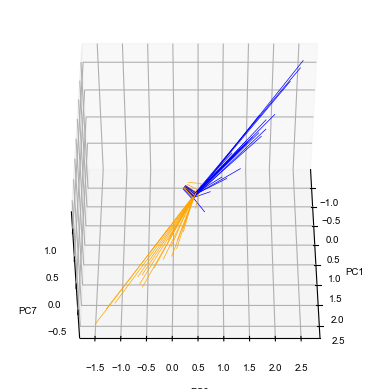

In [20]:
## Plot subset of conditions on multiple objsets

objset = list(range(20))
conds = [0, 2]

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, (objs, cd) in enumerate(itertools.product(objset, conds)):
    feat_name = ''.join([str(fn) for fn in conditions[objs, cd]])
    color = 'blue' if (condition_means_pca[objs][cd][3, 2] > 0.5) else 'orange'
    ax.plot(condition_means_pca[objs][cd][0:3, 0], condition_means_pca[objs][cd][0:3, 2], 
        condition_means_pca[objs][cd][0:3, 6], linewidth=0.5, label=feat_name, color=color)
ax.set_xlabel('PC1'); ax.set_ylabel('PC3'); ax.set_zlabel('PC7')

ax.view_init(45, 0)

Trajectory endpoints lie approximately along a line. To verify that flipping object presentation drives the network in the opposite direction, we can compute the angle between trajectories for the different object presentation orders on each object set. 

Text(0, 0.5, 'Count')

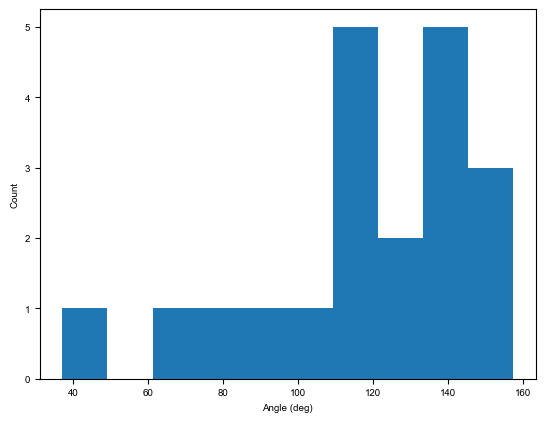

In [21]:
## Compute angles between initial object presentation trajectories

objset = list(range(20))

angle_list = []
for i, objs in enumerate(objset):
    diff_left = condition_means_pca[objs][0][2, :12] - condition_means_pca[objs][0][1, :12] # only first 12 PCs
    diff_right = condition_means_pca[objs][2][2, :12] - condition_means_pca[objs][2][1, :12]
    diff_angle = np.arccos(np.dot(
        diff_left / (np.linalg.norm(diff_left)), 
        diff_right  / (np.linalg.norm(diff_right)))) / np.pi * 180
    angle_list.append(diff_angle)

plt.hist(angle_list)
plt.xlabel('Angle (deg)')
plt.ylabel('Count')

We note that angles between trajectories of opposite object presentations are generally quite high, almost all >90 degrees. Thus, provided that the following dynamics ensure that being driven in the opposite direction results in the opposite choice, this method of input processing implements a fixed stimulus-action mapping that handles making the correct choice regardless of object presentation.

#### 2.2.1 Aside: Adversarial Stimuli

As one would predict from previous plots, we also expect the norm of this trajectory to correlate with the angle difference, as the trajectories with poorer separation between conditions also are much smaller in magnitude. Further, we can try to predict the norm based on the input weights.

In [22]:
## Compute angles between initial object presentation trajectories and their norms

objset = list(range(20))

angle_list = []
norm_list = []
for i, objs in enumerate(objset):
    diff_left = condition_means_pca[objs][0][2, :12] - condition_means_pca[objs][0][1, :12] # only first 12 PCs
    diff_right = condition_means_pca[objs][2][2, :12] - condition_means_pca[objs][2][1, :12]
    norm_list.append((np.linalg.norm(diff_left), np.linalg.norm(diff_right)))
    diff_angle = np.arccos(np.dot(
        diff_left / (np.linalg.norm(diff_left)), 
        diff_right  / (np.linalg.norm(diff_right)))) / np.pi * 180
    angle_list.append(diff_angle)

In [23]:
## Predict trajectory norm from object diff and weight diff

obj_diffs = np.stack([(o[1] - o[0]) for o in obj_list])
obj_diff_weights = (obj_right_weights_pca - obj_left_weights_pca)[:, :12]

pred_norms = np.array([
    np.linalg.norm(obj_diffs[i][None, :] @ obj_diff_weights) for i in range(20)
])

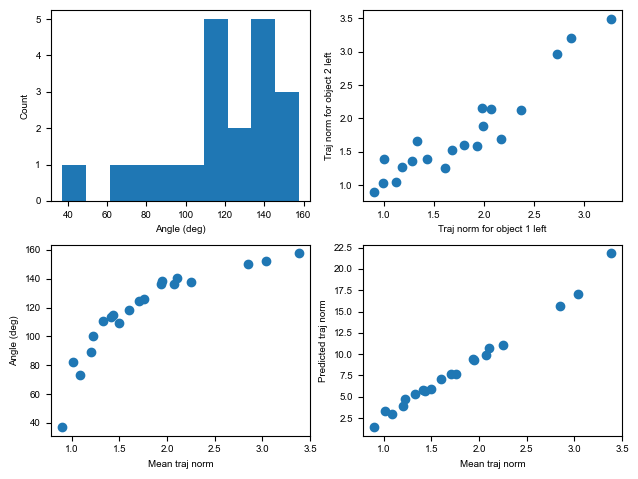

In [24]:
# Plot results

fig, axs = plt.subplots(2, 2)
axs[0][0].hist(angle_list)
axs[0][0].set_xlabel('Angle (deg)')
axs[0][0].set_ylabel('Count')

axs[0][1].scatter(*zip(*norm_list))
axs[0][1].set_xlabel('Traj norm for object 1 left')
axs[0][1].set_ylabel('Traj norm for object 2 left')

axs[1][0].scatter([np.mean(pair) for pair in norm_list], angle_list)
axs[1][0].set_xlabel('Mean traj norm')
axs[1][0].set_ylabel('Angle (deg)')

axs[1][1].scatter([np.mean(pair) for pair in norm_list], pred_norms)
axs[1][1].set_xlabel('Mean traj norm')
axs[1][1].set_ylabel('Predicted traj norm')

plt.tight_layout()

The angle between trajectories is correlated with the norm of the trajectories. Further, the norm of the trajectories is well-predicted from the difference vector between objects in each pair and the RNN input weights.

This suggests that we can compute a difference vector that has minimal effect on the network and generate adversarial stimuli with it.

In [25]:
# Find adversarial difference vector and create two orthogonal objects with it

advrs_diff = np.random.normal(0.0, 1.0, size=5)

# Repeated Gram-Schmidt to first build orth basis
axis_order = np.argsort(np.linalg.norm(obj_diff_weights, axis=0))[::-1][:4]
basis = [obj_diff_weights[:, axis_order[0]] / np.linalg.norm(obj_diff_weights[:, axis_order[0]])]
for i in axis_order[1:]:
    new_basis_vec = obj_diff_weights[:, i]
    for basis_vec in basis:
        new_basis_vec = ortho(basis_vec, new_basis_vec)[1]
        new_basis_vec /= np.linalg.norm(new_basis_vec)
    basis.append(new_basis_vec)

# Orthogonalize advrs_diff from basis
for basis_vec in basis:
    advrs_diff = ortho(basis_vec, advrs_diff)[1]
    advrs_diff /= np.linalg.norm(advrs_diff)

# Arbitrary construction of orthogonal objects with advrs_diff difference vector
obj1 = -advrs_diff / 2 + (obj_diff_weights[:, 2] / np.linalg.norm(obj_diff_weights[:, 2])) / 2
obj2 = advrs_diff / 2 + (obj_diff_weights[:, 2] / np.linalg.norm(obj_diff_weights[:, 2])) / 2

Running the network on tasks with these adversarial objects:

Text(0, 0.5, 'Avg Performance')

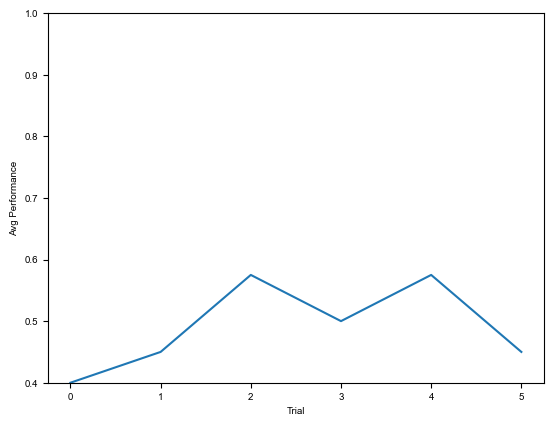

In [26]:
# Run model on task

num_episodes = 40
episode_count = 0

ob, _ = task.reset()
task.unwrapped.obj1_builder = lambda: obj1
task.unwrapped.obj2_builder = lambda: obj2
task.unwrapped.reward_idx = np.random.choice([0, 1])
_ = task.new_trial()
task.unwrapped.num_tr -= 1
task.unwrapped.t = 0
task.unwrapped.t_ind = 0

hx = model.rnn.build_initial_state(1, pl_module.device, pl_module.dtype)

avg_episode_performance = np.zeros(6, dtype=float)
episode_performance = []
trial_count = 0

while episode_count < num_episodes:
    action_logits, value, hx = model(
        torch.from_numpy(ob).to(device=pl_module.device, dtype=pl_module.dtype), 
        hx=hx, 
        cached=True)
    action = action_logits.sample().detach().cpu().numpy()

    ob, reward, done, trunc, info = task.step(action)

    if info.get('new_trial', False):
        trial_count += 1
        episode_performance.append(info.get('performance', 0.0))
        if trial_count == 6:
            avg_episode_performance += np.array(episode_performance).squeeze() / num_episodes
            trial_count = 0
            episode_performance = []
            episode_count += 1
            
            ob, _ = task.reset()
            task.unwrapped.obj1_builder = lambda: obj1
            task.unwrapped.obj2_builder = lambda: obj2
            task.unwrapped.reward_idx = np.random.choice([0, 1])
            _ = task.new_trial()
            task.unwrapped.num_tr -= 1
            task.unwrapped.t = 0
            task.unwrapped.t_ind = 0

plt.plot(avg_episode_performance)
plt.ylim(0.4, 1.0)
plt.xlabel('Trial')
plt.ylabel('Avg Performance')

Performance is very poor, despite the objects still being orthogonal to each other and of typical magnitude. This suggests that the network's object representation/processing strategy is not biologically realistic. Like with many ANNs, the susceptibility to adversarial stimuli is a significant distinguishing characteristic from biological intelligences.

### 2.3 Choice Dynamics

We have now established that the network's input weights essentially compute the difference between the left and right objects, ensuring that when their presentation is reversed, the network is driven in the opposite direction. We now explore how the effects of these inputs through the stimulus and delay periods results in action choice.

#### 2.3.1 Decision-period Dynamics

First, we look at how position along the choice axis at the end of the delay period relates to choice.

In [27]:
decision_stim = np.concatenate([
    np.array([0.]), # Go cue = fix cue -> 0
    np.array([0., 0., 0., 0., 0.]), # objects not shown
    np.array([0., 0., 0., 0., 0.]),
    np.array([1., 0., 0., 0.]), # past action = fix, no reward
])

fixrange = np.arange(-1.5, 1.0, 0.1)
choicerange = np.arange(-2.0, 2.0, 0.1)

def inverse_transform(fix, choice, pca_fact):
    base = fix[:, None] * proj_fix_choice[:, 0][None, :] + choice[:, None] * proj_fix_choice[:, 1][None, :]
    base += pca_ext.inverse_transform(pca_fact)
    return base

slice_pc1 = [0, 1]
slice_pc2 = [0, 1]
num_slices = len(slice_pc1) * len(slice_pc2)

delta = np.empty((num_slices, len(fixrange), len(choicerange), 2))

for n, (spc1, spc2) in enumerate(itertools.product(slice_pc1, slice_pc2)):
    pca_fact = np.zeros((len(choicerange), 254))
    pca_fact[:, 0] = spc1
    pca_fact[:, 1] = spc2
    for i, x in enumerate(fixrange):
        fix = np.full(len(choicerange), x)
        hx = inverse_transform(fix, choicerange, pca_fact)
        next_state = model.rnn.rnn_cell(
            torch.from_numpy(decision_stim).to(pl_module.dtype).unsqueeze(0).repeat((len(choicerange),1)),
            torch.from_numpy(hx).to(pl_module.dtype),
            cached=True,
        ).detach().cpu().numpy().squeeze()
        state_delta = np.squeeze((next_state - hx) @ proj_fix_choice)
        delta[n,i,:,:] = state_delta

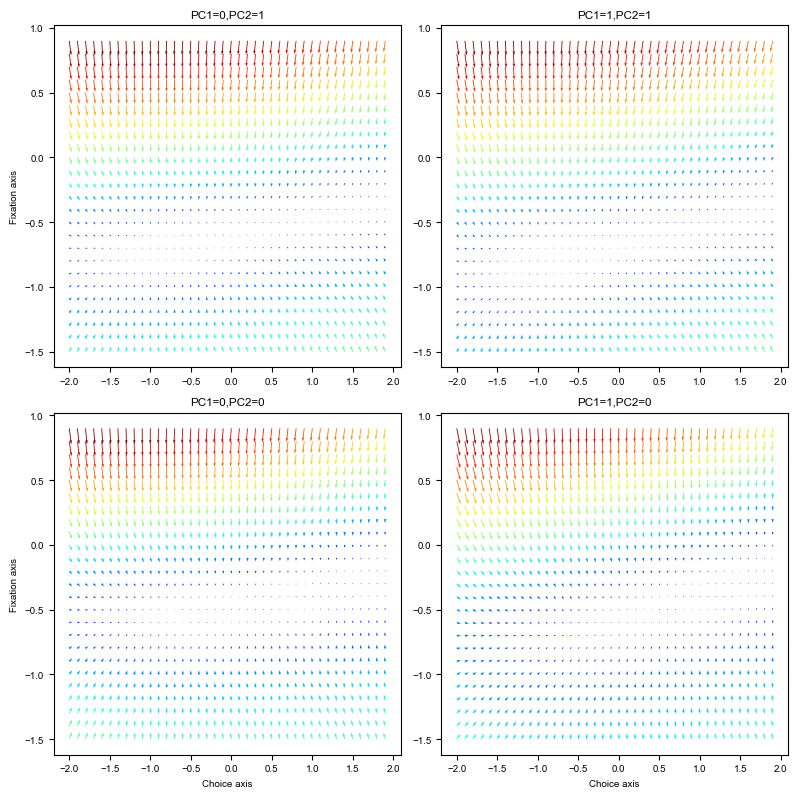

In [28]:
fig, axs = plt.subplots(len(slice_pc2), len(slice_pc1), figsize=(len(slice_pc1)*4, len(slice_pc2)*4))

for n, (i, j) in enumerate(itertools.product(range(len(slice_pc1)), range(len(slice_pc2)))):
    axs[len(slice_pc2)-1-j,i].quiver(
        *np.meshgrid(choicerange, fixrange, indexing='xy'), 
        delta[n, :, :, 1], delta[n, :, :, 0],
        np.linalg.norm(delta[n, :, :, :], axis=-1),
        cmap=plt.cm.jet,
    )
    axs[len(slice_pc2)-1-j,i].set_title(f'PC1={slice_pc1[i]},PC2={slice_pc2[j]}')
    if (len(slice_pc2)-1-j) == (len(slice_pc2)-1):
        axs[len(slice_pc2)-1-j,i].set_xlabel('Choice axis')
    if i == 0:
        axs[len(slice_pc2)-1-j,i].set_ylabel('Fixation axis')
plt.tight_layout()

Across different slices along the first two remaining PCs, decision dynamics on the choice-fixation plane are generally quite consistent, driving toward lower fixation strength (i.e. breaking fixation) while generally maintaining position along the choice axis. These dynamics vaguely resemble a line attractor. Thus, the network's position along the choice axis at the end of the delay period should be highly predictive of its eventual choice.

#### 2.3.2 Stimulus and Delay Period Dynamics

As stimulus and delay period activity should stay roughly constant on the fixation axis, we can focus on only the choice axis and the next two PCs.

We can first single out two particular conditions, '0000' and '1000' for a single object set. These two are interesting because they do not differ in object stimuli but do differ in which object is rewarded, meaning their second trials should result in different choices.

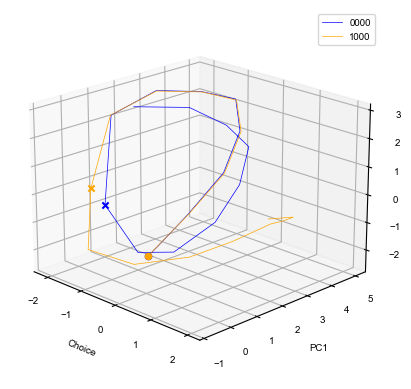

In [29]:
## Plot subset of conditions on multiple objsets

objset = [0]
conds = [0, 4]

fig = plt.figure()
ax = plt.axes(projection='3d')

for i, (objs, cd) in enumerate(itertools.product(objset, conds)):
    feat_name = ''.join([str(fn) for fn in conditions[objs, cd]])[1:]
    color = 'blue' if cd == 0 else 'orange'
    ax.plot(condition_ext_means_pca[objs][cd][:, 1], condition_ext_means_pca[objs][cd][:, 2], 
        condition_ext_means_pca[objs][cd][:, 3], linewidth=0.5, label=feat_name, color=color)
    ax.scatter(condition_ext_means_pca[objs][cd][0, 1], condition_ext_means_pca[objs][cd][0, 2], 
        condition_ext_means_pca[objs][cd][0, 3], marker='o', color=color)
    ax.scatter(condition_ext_means_pca[objs][cd][9, 1], condition_ext_means_pca[objs][cd][9, 2], 
        condition_ext_means_pca[objs][cd][9, 3], marker='x', color=color)
ax.set_xlabel('Choice'); ax.set_ylabel('PC1'); ax.set_zlabel('PC2')
plt.legend()

ax.view_init(20, -45)

The network follows the exact same trajectory for the first trial in both cases, but upon receiving no reward in condition '1000', the network ends up in a state with a lower value along PC2, where dynamics lead the state toward the opposite choice. So, we need to look at how Choice-PC1-PC2 dynamics enable these opposite choices in response to identical stimuli (apart from reward).

In [30]:
## Prepare data for simulation

objset = 0

left_stim = np.concatenate([
    np.array([1.]),
    obj_list[objset][0], # object 1 on left
    obj_list[objset][1],
    np.array([1., 0., 0., 0.]), # past action = fix, no reward
])

right_stim = np.concatenate([
    np.array([1.]),
    obj_list[objset][1], # object 2 on left
    obj_list[objset][0],
    np.array([1., 0., 0., 0.]), # past action = fix, no reward
])

delay_stim = np.concatenate([
    np.array([1.]),
    np.array([0., 0., 0., 0., 0.]), # no object presented
    np.array([0., 0., 0., 0., 0.]), 
    np.array([1., 0., 0., 0.]), # past action = fix, no reward
])

choicerange = np.arange(-2.0, 2.01, 0.2)
pc1range = np.arange(-5.0, 5.01, 0.5)
pc2range = np.arange(-3.0, 3.01, 0.3)

def transform(state):
    if len(state.shape) == 1:
        state = state[None, :]
    proj = state @ proj_fix_choice
    ext = state - proj @ proj_fix_choice.T
    ext = pca_ext.transform(ext)
    return np.concatenate([proj, ext], axis=1)

def inverse_transform(fix, choice, pca_fact):
    base = fix[:, None] * proj_fix_choice[:, 0][None, :] + choice[:, None] * proj_fix_choice[:, 1][None, :]
    base += pca_ext.inverse_transform(pca_fact)
    return base

In [31]:
## Gradient field for left object 1

left_delta = np.empty((len(choicerange), len(pc1range), len(pc2range), 3))

for n, ch in enumerate(choicerange):
    for i, spc1 in enumerate(pc1range):
        pca_fact = np.zeros((len(pc2range), 254))
        pca_fact[:, 0] = spc1
        pca_fact[:, 1] = pc2range
        fix = np.full(len(pc2range), 0.0)
        choice = np.full(len(pc2range), ch)
        hx = inverse_transform(fix, choice, pca_fact)
        next_state = model.rnn.rnn_cell(
            torch.from_numpy(left_stim).to(pl_module.dtype).unsqueeze(0).repeat((len(pc2range),1)),
            torch.from_numpy(hx).to(pl_module.dtype),
            cached=True,
        ).detach().cpu().numpy().squeeze()
        state_delta = (transform(next_state) - transform(hx)).squeeze()
        left_delta[n,i,:,:] = state_delta[:, 1:4]

In [32]:
## Gradient field for right object 1

right_delta = np.empty((len(choicerange), len(pc1range), len(pc2range), 3))

for n, ch in enumerate(choicerange):
    for i, spc1 in enumerate(pc1range):
        pca_fact = np.zeros((len(pc2range), 254))
        pca_fact[:, 0] = spc1
        pca_fact[:, 1] = pc2range
        fix = np.full(len(pc2range), 0.0)
        choice = np.full(len(pc2range), ch)
        hx = inverse_transform(fix, choice, pca_fact)
        next_state = model.rnn.rnn_cell(
            torch.from_numpy(right_stim).to(pl_module.dtype).unsqueeze(0).repeat((len(pc2range),1)),
            torch.from_numpy(hx).to(pl_module.dtype),
            cached=True,
        ).detach().cpu().numpy().squeeze()
        state_delta = (transform(next_state) - transform(hx)).squeeze()
        right_delta[n,i,:,:] = state_delta[:, 1:4]

In [33]:
## Gradient field for delay

delay_delta = np.empty((len(choicerange), len(pc1range), len(pc2range), 3))

for n, ch in enumerate(choicerange):
    for i, spc1 in enumerate(pc1range):
        pca_fact = np.zeros((len(pc2range), 254))
        pca_fact[:, 0] = spc1
        pca_fact[:, 1] = pc2range
        fix = np.full(len(pc2range), 0.0)
        choice = np.full(len(pc2range), ch)
        hx = inverse_transform(fix, choice, pca_fact)
        next_state = model.rnn.rnn_cell(
            torch.from_numpy(delay_stim).to(pl_module.dtype).unsqueeze(0).repeat((len(pc2range),1)),
            torch.from_numpy(hx).to(pl_module.dtype),
            cached=True,
        ).detach().cpu().numpy().squeeze()
        state_delta = (transform(next_state) - transform(hx)).squeeze()
        delay_delta[n,i,:,:] = state_delta[:, 1:4]

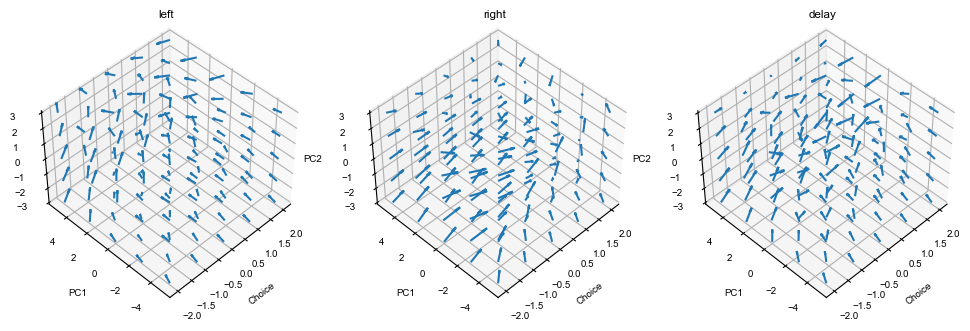

In [34]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

x, y, z = np.meshgrid(choicerange[::5], pc1range[::5], pc2range[::5], indexing='xy')
for name, data, ax in zip(['left', 'right', 'delay'], [left_delta, right_delta, delay_delta], [ax1, ax2, ax3]):
    ax.quiver(x, y, z, 
        data[::5,::5,::5,0].transpose(1,0,2), 
        data[::5,::5,::5,1].transpose(1,0,2), 
        data[::5,::5,::5,2].transpose(1,0,2),
        length=0.6, normalize=True)
    ax.set_xlabel('Choice'); ax.set_ylabel('PC1'); ax.set_zlabel('PC2')
    ax.set_title(name)

    ax.view_init(45,-135)


This is pretty messy and hard to interpret, but you might notice that trajectories all tend to flow upward along PC2. If we single out the "left" dynamics, we can see this more clearly.

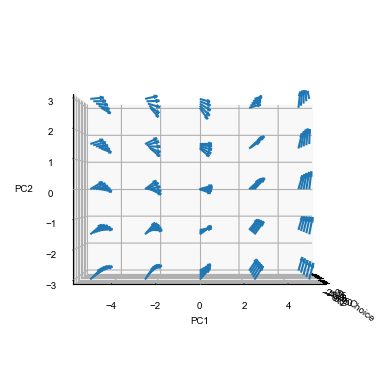

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.quiver(x, y, z, 
    left_delta[::5,::5,::5,0].transpose(1,0,2), 
    left_delta[::5,::5,::5,1].transpose(1,0,2), 
    left_delta[::5,::5,::5,2].transpose(1,0,2),
    length=0.6, normalize=True)

ax.set_xlabel('Choice'); ax.set_ylabel('PC1'); ax.set_zlabel('PC2')

ax.view_init(0,0)

From this perspective, we can see that motion tends upward along PC2, but this trend weakens as we move to lower values along the choice axis (into the page) and on PC2 (to the left). Looking at some network trajectories, we can better visualize how the network uses these dynamics.

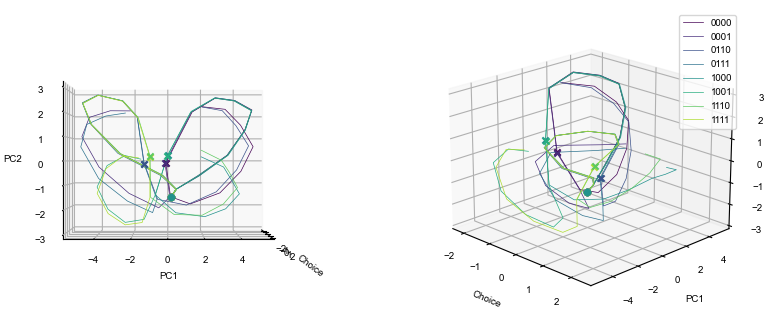

In [36]:
## Plot subset of conditions on multiple objsets

objset = [0]
conds = [0, 1, 2, 3, 4, 5, 6, 7]

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for i, (objs, cd) in enumerate(itertools.product(objset, conds)):
    feat_name = ''.join([str(fn) for fn in conditions[objs, cd]])[1:]
    color = plt.get_cmap('viridis')(i / len(conds))
    for ax in [ax1, ax2]:
        ax.plot(condition_ext_means_pca[objs][cd][:, 1], condition_ext_means_pca[objs][cd][:, 2], 
            condition_ext_means_pca[objs][cd][:, 3], linewidth=0.5, label=feat_name, color=color)
        ax.scatter(condition_ext_means_pca[objs][cd][0, 1], condition_ext_means_pca[objs][cd][0, 2], 
            condition_ext_means_pca[objs][cd][0, 3], marker='o', color=color)
        ax.scatter(condition_ext_means_pca[objs][cd][9, 1], condition_ext_means_pca[objs][cd][9, 2], 
            condition_ext_means_pca[objs][cd][9, 3], marker='x', color=color)
ax1.set_xlabel('Choice'); ax1.set_ylabel('PC1'); ax1.set_zlabel('PC2')
ax2.set_xlabel('Choice'); ax2.set_ylabel('PC1'); ax2.set_zlabel('PC2')
plt.legend()

ax1.view_init(0, 0)
ax2.view_init(20, -45)

Half of the trials (the ones where object 2 is rewarded) go deeper along PC2 and end at around PC2 = 0, while the other half ascend more rapidly and end at around PC2 = 2 or 2.5. It's not easy to see from the plot on the right, but the network state at the beginning of trial 2 stimulus presentation is further to the left along both the choice axis and PC1 for trials where object 2 is rewarded. Based on the earlier observation that the upward PC2 movement is weaker (or even reversed) as you move left along the choice axis and PC1, this may cause the network state to take lower trajectories along PC2.

To see the effect of where along PC2 the network resides, we can plot Choice-PC1 dynamics along slices of PC2.

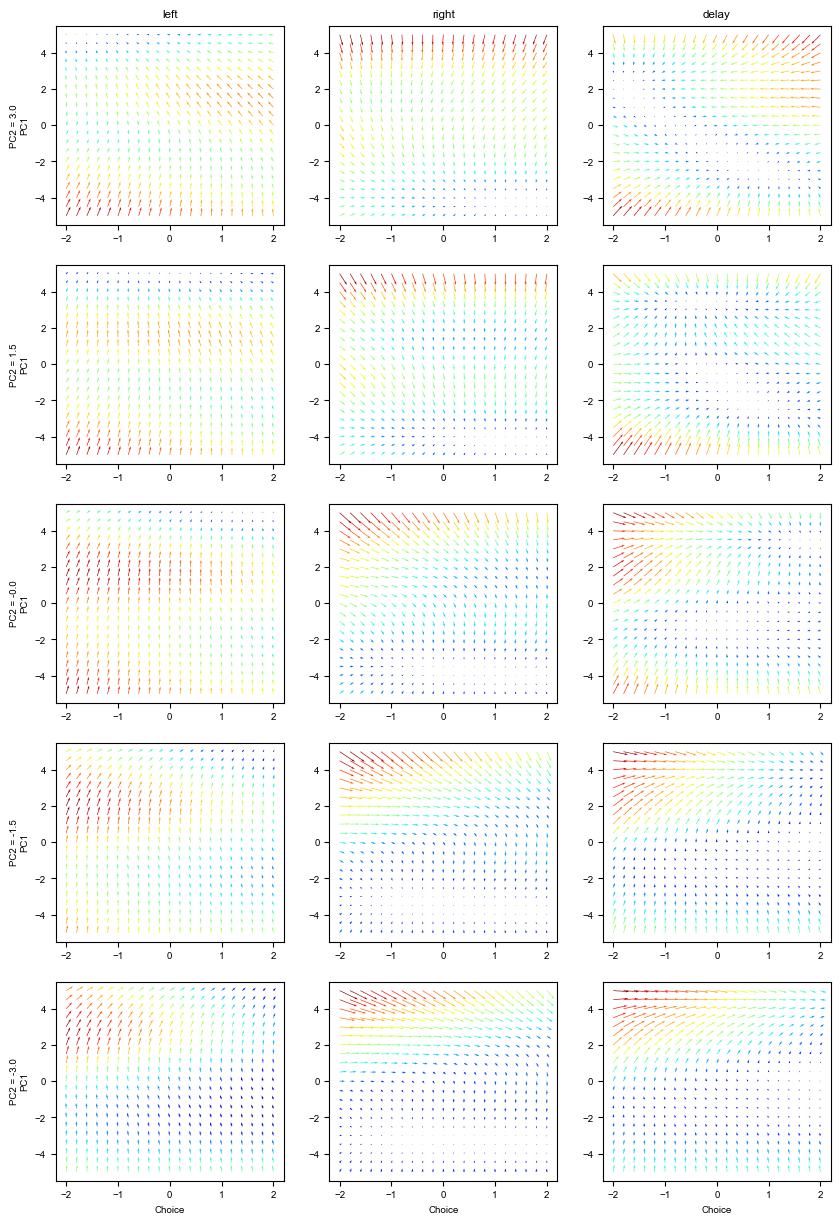

In [37]:
fig, axs = plt.subplots(5, 3, figsize=(10,15))

for i in range(5):
    if i == 0:
        [axs[4-i,n].set_xlabel('Choice') for n in range(3)]
    axs[4-i,0].quiver(*np.meshgrid(choicerange, pc1range, indexing='xy'), 
        left_delta[:, :, 5*i, 0].T, left_delta[:, :, 5*i, 1].T, 
        np.linalg.norm(left_delta[:, :, 5*i, :2], axis=-1).T, cmap=plt.cm.jet)
    axs[4-i,1].quiver(*np.meshgrid(choicerange, pc1range, indexing='xy'), 
        right_delta[:, :, 5*i, 0].T, right_delta[:, :, 5*i, 1].T, 
        np.linalg.norm(right_delta[:, :, 5*i, :2], axis=-1).T, cmap=plt.cm.jet)
    axs[4-i,2].quiver(*np.meshgrid(choicerange, pc1range, indexing='xy'), 
        delay_delta[:, :, 5*i, 0].T, delay_delta[:, :, 5*i, 1].T, 
        np.linalg.norm(delay_delta[:, :, 5*i, :2], axis=-1).T, cmap=plt.cm.jet)
    axs[4-i,0].set_ylabel(f'PC2 = {round(pc2range[5*i], 2)}\nPC1')
    if i == 4:
        [axs[4-i,n].set_title(name) for n, name in enumerate(['left', 'right', 'delay'])]

Keeping in mind that networks tend to end up at either PC2 = 0 or PC2 = 2 or 2.5, these plots give the following general picture of the choice dynamics:
1. During stimulus presentation, object 1 on left vs. object 1 on right drive the network in opposite directions, most clearly along PC1, where object 1 on left drives the network upward and object 1 on right drives it downward.
2. As PC2 increases, the direction along the choice axis that the network is drawn to flips for both left and right object presentations. At PC2 = -3, the network flows rightward for left input and roughly downward/slightly leftward for right input. (Note that the upper portion of that plot, where the network moves right, is not a state that the network would typically find itself in, since right input drives the network down, so the relevant portion of the plot is the bottom half) At PC2 = +3, the network flows leftward for left input and rightward for right input. Thus, moving along PC2 reverses the action policy the network follows.
3. In the delay period, the network converges on slow regions of the vector field. Importantly, the orientation of these slow points flips between PC2 = 0 and PC2 = 3. At PC2 = 0, the lower (along PC1) slow region is further to the left along the choice axis than the upper slow region. At PC2 = 3, this is flipped and the lower slow region is further to the right.

Thus, this dynamical structure implements two opposite policies that can be switched between depending on the network initial state at stimulus presentation time. The network, when initialized at 0, initially follows the policy ending at around PC2 = 2 to 3, which we'll call the "default" policy from here on.

### 2.4 Feedback-based Policy Adjustment Dynamics

The last piece of the puzzle is how the network adjusts its policy based on feedback and correctly sets its initial state to follow the correct policy. Importantly, you may have noticed that the dynamics suggest that the final state at the end of the delay period encodes not only the choice but also the current policy, since the two opposite policies end up at different places along PC1 and PC2. We can verify that this is the case.

In [38]:
## Extract final states for each trial and project into PC and fix-choice-PC space

trial_ends = states_c[:, :, :, [8, 17], :]

trial_ends_flat = trial_ends.reshape(-1, trial_ends.shape[-1])
trial_ends_pca = pca_allcond.transform(trial_ends_flat)
trial_ends_pca = trial_ends_pca.reshape(trial_ends.shape)

trial_ends_proj = trial_ends_flat @ proj_fix_choice
trial_ends_ext = trial_ends_flat - trial_ends_proj @ proj_fix_choice.T
trial_ends_ext_pca = pca_ext.transform(trial_ends_ext)
trial_ends_ext_pca = np.concatenate([trial_ends_proj, trial_ends_ext_pca], axis=-1)
trial_ends_ext_pca = trial_ends_ext_pca.reshape(trial_ends.shape)

Text(0.5, 0, 'PC2')

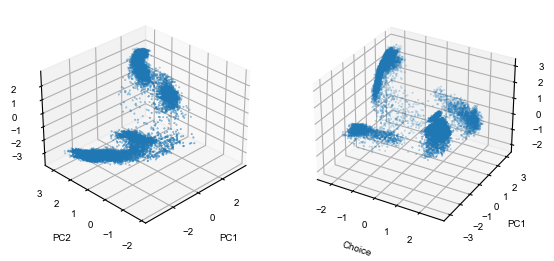

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(
    trial_ends_pca.reshape(-1, 256)[:, 0], 
    trial_ends_pca.reshape(-1, 256)[:, 1], 
    trial_ends_pca.reshape(-1, 256)[:, 2],
    s=0.1)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.view_init(30, 225)

ax2.scatter(
    trial_ends_ext_pca.reshape(-1, 256)[:, 1], 
    trial_ends_ext_pca.reshape(-1, 256)[:, 2], 
    trial_ends_ext_pca.reshape(-1, 256)[:, 3],
    s=0.1)
ax2.set_xlabel('Choice')
ax2.set_ylabel('PC1')
ax2.set_zlabel('PC2')

There are clearly 4 clusters in Choice-PC1-PC2 space. The number of clusters is not as apparent in plain PC space. If we color these points by their past action and which object is rewarded, clearer structure may be visible.

In [40]:
## Determine clusters

# On first trial, only clusters 1 and 2 are possible based on choice - this is default policy
clusters_first = (conditions[:, :, 3] == 1).astype(int)
# On second trial, clusters 3 and 4 are introduced if the policy switches from trial 1 to 2
# Policy switch occurs if 1) network is on object 1 left => action left policy and reward_idx == 1 or 
# 2) network is on object 1 left => action right policy and reward_idx == 0, which can be expressed as
# reward_idx == (object_1_left == action_left)
# Also, action is known to provide reward, so action can be computed by reward_idx != obj_2_left
clusters_second = 2 * (conditions[:, :, 1] == (conditions[:, :, 2] == conditions[:, :, 3])).astype(int) + \
    (conditions[:, :, 1] != conditions[:, :, 4]).astype(int)

clusters = np.stack([clusters_first, clusters_second], axis=2)
clusters = np.tile(clusters[:, :, None, :], (1, 1, 40, 1))

Text(0.5, 0, 'PC2')

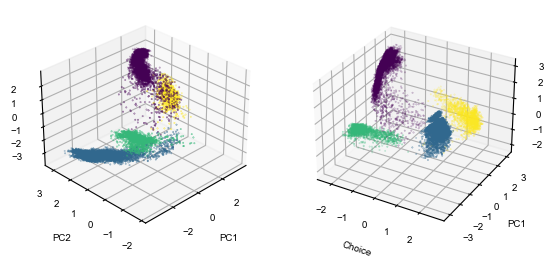

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(
    trial_ends_pca.reshape(-1, 256)[:, 0], 
    trial_ends_pca.reshape(-1, 256)[:, 1], 
    trial_ends_pca.reshape(-1, 256)[:, 2],
    c=clusters.reshape(-1, 1).squeeze(),
    cmap=plt.cm.viridis,
    s=0.1)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.view_init(30, 225)

ax2.scatter(
    trial_ends_ext_pca.reshape(-1, 256)[:, 1], 
    trial_ends_ext_pca.reshape(-1, 256)[:, 2], 
    trial_ends_ext_pca.reshape(-1, 256)[:, 3],
    c=clusters.reshape(-1, 1).squeeze(),
    cmap=plt.cm.viridis,
    s=0.1)
ax2.set_xlabel('Choice')
ax2.set_ylabel('PC1')
ax2.set_zlabel('PC2')

Coloring by these manually assigned clusters very clearly and cleanly separates out the four possible cases. The purple cluster is choosing left when the network follows its initial "default" policy (simply the policy it always follows when initialized to 0). The blue is when the network chooses right when following the "default" policy. Turquoise is when the network chooses left after switching based on feedback to the opposite policy, and yellow is when the network chooses right after switching policies.

What is important about these clusters is how the subsequent network state depends on whether a reward is received. We can simulate response to either reward or no reward for all of these points.

In [42]:
## Prepare network inputs for simulation

left_reward_input = np.concatenate([
    np.array([1.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 1., 0., 1.])
])

right_reward_input = np.concatenate([
    np.array([1.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 1., 1.])
])

left_noreward_input = np.concatenate([
    np.array([1.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 1., 0., 0.])
])

right_noreward_input = np.concatenate([
    np.array([1.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 1., 0.])
])

flat_clusters = clusters.reshape(-1, 1)
left_mask = np.isin(flat_clusters, [0, 2]).squeeze()

trial_ends_orig = states[:, :, :, [8, 17], :]
trial_ends_orig_flat = trial_ends_orig.reshape(-1, trial_ends_orig.shape[-1])

trial_ends_flat_left = trial_ends_orig_flat[left_mask]
trial_ends_flat_right = trial_ends_orig_flat[~left_mask]

next_state_noreward = np.empty(trial_ends_orig_flat.shape)
next_state_reward = np.empty(trial_ends_orig_flat.shape)

In [43]:
# Simulate one forward step for all left choice states

batch_size = 320

batch_noreward_input = torch.from_numpy(
    np.tile(left_noreward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
batch_reward_input = torch.from_numpy(
    np.tile(left_reward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
for i in range(0, trial_ends_flat_left.shape[0], batch_size):
    assign_idxs = np.arange(trial_ends_orig_flat.shape[0])[left_mask][i:(i+batch_size)]
    hx = trial_ends_flat_left[i:(i+batch_size),:]
    hx = torch.from_numpy(hx).to(pl_module.dtype)
    with torch.no_grad():
        next_hx = model.rnn.rnn_cell(batch_noreward_input, hx, cached=True).detach().cpu().numpy()
        next_state_noreward[assign_idxs] = next_hx
        next_hx = model.rnn.rnn_cell(batch_reward_input, hx, cached=True).detach().cpu().numpy()
        next_state_reward[assign_idxs] = next_hx

In [44]:
# Simulate one forward step for all right choice states

batch_size = 320

batch_noreward_input = torch.from_numpy(
    np.tile(right_noreward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
batch_reward_input = torch.from_numpy(
    np.tile(right_reward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
for i in range(0, trial_ends_flat_right.shape[0], batch_size):
    assign_idxs = np.arange(trial_ends_orig_flat.shape[0])[~left_mask][i:(i+batch_size)]
    hx = trial_ends_flat_right[i:(i+batch_size),:]
    hx = torch.from_numpy(hx).to(pl_module.dtype)
    with torch.no_grad():
        next_hx = model.rnn.rnn_cell(batch_noreward_input, hx, cached=True).detach().cpu().numpy()
        next_state_noreward[assign_idxs] = next_hx
        next_hx = model.rnn.rnn_cell(batch_reward_input, hx, cached=True).detach().cpu().numpy()
        next_state_reward[assign_idxs] = next_hx

In [45]:
## Map points into PC and Fix-Choice-PC space

next_state_noreward_pca = pca_allcond.transform(next_state_noreward - all_mean[0,0,0])
next_state_noreward_pca = next_state_noreward_pca.reshape(trial_ends_orig.shape)
next_state_reward_pca = pca_allcond.transform(next_state_reward - all_mean[0,0,0])
next_state_reward_pca = next_state_reward_pca.reshape(trial_ends_orig.shape)

next_state_noreward_proj = (next_state_noreward - all_mean[0,0,0]) @ proj_fix_choice
next_state_noreward_ext = (next_state_noreward - all_mean[0,0,0]) - trial_ends_proj @ proj_fix_choice.T
next_state_noreward_ext_pca = pca_ext.transform(next_state_noreward_ext)
next_state_noreward_ext_pca = np.concatenate([next_state_noreward_proj, next_state_noreward_ext_pca], axis=-1)
next_state_noreward_ext_pca = next_state_noreward_ext_pca.reshape(trial_ends_orig.shape)

next_state_reward_proj = (next_state_reward - all_mean[0,0,0]) @ proj_fix_choice
next_state_reward_ext = (next_state_reward - all_mean[0,0,0]) - trial_ends_proj @ proj_fix_choice.T
next_state_reward_ext_pca = pca_ext.transform(next_state_reward_ext)
next_state_reward_ext_pca = np.concatenate([next_state_reward_proj, next_state_reward_ext_pca], axis=-1)
next_state_reward_ext_pca = next_state_reward_ext_pca.reshape(trial_ends_orig.shape)

Text(0.5, 0, 'PC2')

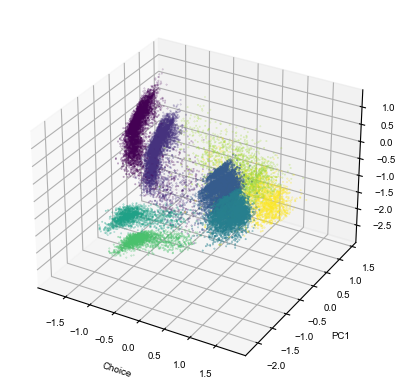

In [46]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

next_state_ext_pca = np.concatenate([
    next_state_noreward_ext_pca,
    next_state_reward_ext_pca,
], axis=0)
next_state_clusters = np.concatenate([
    clusters,
    clusters + 0.5
], axis=0)

ax.scatter(
    next_state_ext_pca.reshape(-1, 256)[:, 1], 
    next_state_ext_pca.reshape(-1, 256)[:, 2], 
    next_state_ext_pca.reshape(-1, 256)[:, 3],
    c=next_state_clusters.reshape(-1, 1).squeeze(),
    cmap=plt.cm.viridis,
    s=0.1)
ax.set_xlabel('Choice')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

There is not substantial separation between trajectories immediately following feedback, as the original four clusters are still distinguishable. In each original cluster, the lighter color corresponds to trials that received reward, while the darker color did not receive reward. In the yellow and turquoise clusters, receiving reward keeps the state further down along PC2, reinforcing the current policy, while not receiving reward does the opposite. The effect of reward on the purple and blue clusters is not as immediately apparent. We can further run the networks through the subsequent fixation period and compare where the states end up.

In [47]:
## Prepare inputs for simulation

batch_size = 320

fix_input = np.concatenate([
    np.array([1.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([0., 0., 0., 0., 0.]),
    np.array([1., 0., 0., 0.]),
])

fix_input = torch.from_numpy(
    np.tile(fix_input[None, :], (batch_size, 1))).to(pl_module.dtype)

fix_state_noreward = np.empty(trial_ends_orig_flat.shape)
fix_state_reward = np.empty(trial_ends_orig_flat.shape)

In [48]:
# Simulate 3 forward steps for all left choice states

batch_noreward_input = torch.from_numpy(
    np.tile(left_noreward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
batch_reward_input = torch.from_numpy(
    np.tile(left_reward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
for i in range(0, trial_ends_flat_left.shape[0], batch_size):
    assign_idxs = np.arange(trial_ends_orig_flat.shape[0])[left_mask][i:(i+batch_size)]
    hx = trial_ends_flat_left[i:(i+batch_size),:]
    hx = torch.from_numpy(hx).to(pl_module.dtype)
    with torch.no_grad():
        next_hx = model.rnn.rnn_cell(batch_noreward_input, hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True).detach().cpu().numpy()
        fix_state_noreward[assign_idxs] = next_hx
        next_hx = model.rnn.rnn_cell(batch_reward_input, hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True).detach().cpu().numpy()
        fix_state_reward[assign_idxs] = next_hx

In [49]:
# Simulate 3 forward steps for all right choice states

batch_noreward_input = torch.from_numpy(
    np.tile(right_noreward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
batch_reward_input = torch.from_numpy(
    np.tile(right_reward_input[None, :], (batch_size, 1))).to(pl_module.dtype)
for i in range(0, trial_ends_flat_right.shape[0], batch_size):
    assign_idxs = np.arange(trial_ends_orig_flat.shape[0])[~left_mask][i:(i+batch_size)]
    hx = trial_ends_flat_right[i:(i+batch_size),:]
    hx = torch.from_numpy(hx).to(pl_module.dtype)
    with torch.no_grad():
        next_hx = model.rnn.rnn_cell(batch_noreward_input, hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True).detach().cpu().numpy()
        fix_state_noreward[assign_idxs] = next_hx
        next_hx = model.rnn.rnn_cell(batch_reward_input, hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True)
        next_hx = model.rnn.rnn_cell(fix_input, next_hx, cached=True).detach().cpu().numpy()
        fix_state_reward[assign_idxs] = next_hx

In [50]:
# Map onto PC and Fix-Choice-PC space

fix_state_noreward_pca = pca_allcond.transform(fix_state_noreward - all_mean[0,0,0])
fix_state_noreward_pca = fix_state_noreward_pca.reshape(trial_ends_orig.shape)
fix_state_reward_pca = pca_allcond.transform(fix_state_reward - all_mean[0,0,0])
fix_state_reward_pca = fix_state_reward_pca.reshape(trial_ends_orig.shape)

fix_state_noreward_proj = (fix_state_noreward - all_mean[0,0,0]) @ proj_fix_choice
fix_state_noreward_ext = (fix_state_noreward - all_mean[0,0,0]) - trial_ends_proj @ proj_fix_choice.T
fix_state_noreward_ext_pca = pca_ext.transform(fix_state_noreward_ext)
fix_state_noreward_ext_pca = np.concatenate([fix_state_noreward_proj, fix_state_noreward_ext_pca], axis=-1)
fix_state_noreward_ext_pca = fix_state_noreward_ext_pca.reshape(trial_ends_orig.shape)

fix_state_reward_proj = (fix_state_reward - all_mean[0,0,0]) @ proj_fix_choice
fix_state_reward_ext = (fix_state_reward - all_mean[0,0,0]) - trial_ends_proj @ proj_fix_choice.T
fix_state_reward_ext_pca = pca_ext.transform(fix_state_reward_ext)
fix_state_reward_ext_pca = np.concatenate([fix_state_reward_proj, fix_state_reward_ext_pca], axis=-1)
fix_state_reward_ext_pca = fix_state_reward_ext_pca.reshape(trial_ends_orig.shape)

Text(0.5, 0, 'PC2')

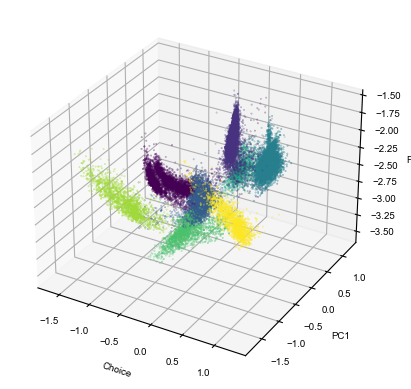

In [51]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fix_state_ext_pca = np.concatenate([
    fix_state_noreward_ext_pca,
    fix_state_reward_ext_pca,
], axis=0)
fix_state_clusters = np.concatenate([
    clusters,
    clusters + 0.5
], axis=0)

ax.scatter(
    fix_state_ext_pca.reshape(-1, 256)[:, 1], 
    fix_state_ext_pca.reshape(-1, 256)[:, 2], 
    fix_state_ext_pca.reshape(-1, 256)[:, 3],
    c=fix_state_clusters.reshape(-1, 1).squeeze(),
    cmap=plt.cm.viridis,
    s=0.1)
ax.set_xlabel('Choice')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

After fixation, the states more clearly separated based on reward. 

The bright yellow and turquoise green states in the center are correctly at low values of PC2 to follow the rewarded "opposite" policy. The dark purple and dull blue-grey also join those two in the center, flipping policies from the "default" as they did not receive reward. 

The lighter purple and greenish-blue to the right are correctly at high values of PC1 and PC2, which will implement the rewarded "default" policy. They are joined by the turquoise cluster, which flipped from the opposite policy. 

Confusingly, the lime green cluster is off to the left instead of joining the others in the upper right. Based on earlier glimpses of the stimulus and delay-period dynamics, it is unclear how this initial state would implement the "default" policy, as lower values of PC1 and choice tend to drive the state down along PC2 instead of upward as expected for the "default" policy.

## 3 Caveats, Future Improvements, etc.

1. "Objects" used in task are low-dimensional and possibly not realistic. Instead, we could use higher-d synthetic inputs or even pre-trained (or task-trained) CNNs with actual visual input. This may not address the issue of adversarial inputs, though.
2. Task design with fixed object set per episode allows for an object difference-based coding scheme. Animals likely use the individual object identities, though. To rectify this, we can use modifications of the task where only the rewarded or unrewarded object is kept constant across trials, but not both.
3. Task design with fixed trial timings, delay periods, and number of trials per episode allow for potentially unrealistic dynamic solutions, whereas typically biological networks do not know exactly how long they need to maintain information and thus probably use something more stable. Randomizing trial timings could help.
4. Delayed-response task design differs (I think?) from the original Harlow task. However, the networks were solving the task too quickly and/or just randomly guessing immediately when I didn't introduce delay. Adding more noise, increasing the time-constant of the RNN, or more heavily penalizing mistakes might help?
5. Lots of holes in this vague explanation of network mechanism, and only one network was analyzed. Would be good to think about more grounded and quantitative measures/methods to analyze the networks, especially something that could be applied without supervision across a bunch of networks. Relying so extensively on visualization of trajectories is questionable
6. Looking a bit too far ahead, but it would be cool to try even more complex tasks, like WCST, which similarly involves inferring rules and rule switches but involves more uncertainty and a greater set of possible rules.